Scoring goals is the hardest thing to do in the game of football. This is why in this analysis I will check, if forwards, whose main role is to score goals, actually score more goals than players in other positions. Data containes number of goals scored by all players in 5 best european leagues. (Spanish, French, German, English and Italian first divisions)  <br>
The analysis is based on data from https://fbref.com, from which I have downloaded player data for 2020/2021 season.

In [2]:
# Importing libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In order to make the dataset, firstly I have downloaded 5 tables with all players stats from top 5 leagues (English, Spanish, German, French and Italian first divisions) onto my computer. Secondly, I have merged them, and deleted all columns except for name, position and number of goals scored.

In [3]:
df = pd.read_csv(r'C:\Users\igors\Desktop\Data Science\2020-2021 player stats.csv')
del df['Unnamed: 0']
df.head()

,1_Player,3_Pos,Performance_Gls
0,Patrick van Aanholt,DF,0
1,Tammy Abraham,FW,6
2,Che Adams,FW,9
3,Tosin Adarabioyo,DF,0
4,Adrián,GK,0


Next step is to clean the data in order for it to properly work.

In [4]:
# Deleting NaN rows (with player name being 'Player') and checking for duplicates
players = df['1_Player']
df = df[players != 'Player']
players.duplicated(keep='first').sum()

234

In [5]:
df.dtypes

1_Player           object
3_Pos              object
Performance_Gls    object
dtype: object

In [6]:
#Converting goals column into integers
df['Performance_Gls'] = df['Performance_Gls'].astype('int64')
df.dtypes

1_Player           object
3_Pos              object
Performance_Gls     int64
dtype: object

In [7]:
# Merging duplicated rows (for players playing in multiple teams during a season)
df['Performance_Gls'] = df.groupby('1_Player')['Performance_Gls'].transform('sum')
df = df.drop_duplicates(subset='1_Player')

In [8]:
df.shape

(2698, 3)

In [9]:
df.describe()

,Performance_Gls
count,2698.000000
mean,1.837287
std,3.449276
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,41.000000


From the describe method we can see, that 50% of all players didn't score a single goal during the whole season. <br>
Let's see the distribution of goals scored.

In [10]:
# Defining ECDF function to visualise distribution
def ecdf(data):
    # n - number of data points
    n = len(data)
    # x - x-data for ECDF
    x = np.sort(data)
    # y - y-data for ECDF
    y = np.arange(1, n+1) / n
    return x, y

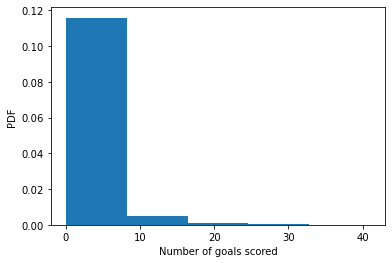

In [11]:
# PDF of goals scored by all players during 2020/2021 season
plt.hist(df['Performance_Gls'], bins=5, density=True)
plt.xlabel('Number of goals scored')
plt.ylabel('PDF')
plt.show()

As shown above, most of the players have scored less than 10 goals. Now let's conduct an ECDF

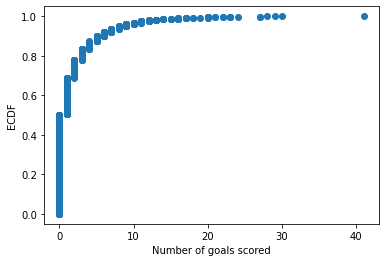

In [12]:
# Computing ECDF for amount of goals scored by player during 2020/2021 season
#n - number of data points
x, y = ecdf(df['Performance_Gls'])
#Generate ECDF plot
plt.scatter(x, y)
plt.xlabel('Number of goals scored')
plt.ylabel('ECDF')
plt.show()

Almost all of the players scored 10 goals of less, and 50% of all players didn't score a single goal. But since dataset contains all players, I have decided to exclude goalkeepers from the data, because all of 205 of them managed to score only 3 goals combined.

In [13]:
goals_by_goalkeepers = df[df['3_Pos'] == 'GK']['Performance_Gls'].sum()
print(f'Combined goals by goalkeepers: {goals_by_goalkeepers}')

Combined goals by goalkeepers: 3


In [14]:
df['3_Pos'].value_counts()

DF       858
MF       551
FW       347
FW,MF    294
MF,FW    226
GK       204
DF,MF     82
MF,DF     75
DF,FW     34
FW,DF     26
GK,MF      1
Name: 3_Pos, dtype: int64

In [15]:
df = df[df['3_Pos'] != 'GK']
df = df[df['3_Pos'] != 'GK,MF']
df['3_Pos'].value_counts()

DF       858
MF       551
FW       347
FW,MF    294
MF,FW    226
DF,MF     82
MF,DF     75
DF,FW     34
FW,DF     26
Name: 3_Pos, dtype: int64

In order to answear the main question, firstly I will compare distributions of goals scored by forwards and players in different possitions.

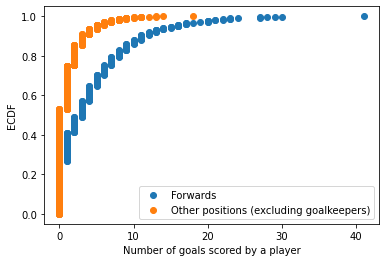

In [16]:
fw_cols = ['FW','FW,MF']
forwards = df.loc[df['3_Pos'].isin(fw_cols)]

rest_cols = ['DF','MF','MF,FW','DF,MF','MF,DF','FW,DF']
rest = df.loc[df['3_Pos'].isin(rest_cols)]

x_fw, y_fw = ecdf(forwards['Performance_Gls'])
plt.scatter(x_fw, y_fw, label='Forwards')

x_rest, y_rest = ecdf(rest['Performance_Gls'])
plt.scatter(x_rest, y_rest, label='Other positions (excluding goalkeepers)')

plt.xlabel('Number of goals scored by a player')
plt.ylabel('ECDF')
plt.legend()
plt.show()

Eyeballing the data suggest that forwards actually do score a lot more goals. <br>
Now let's estimate parameters before performing hypothesis test.

In [17]:
# Difference of means between empirical data
mean_diff = forwards['Performance_Gls'].mean() - rest['Performance_Gls'].mean()
print(f'Difference of means = {mean_diff}')

Difference of means = 3.2716919897918024


In order to test the hypothesis, I will simulate 2020/2021 season 10 000 times in order to get a big sample of permutated data.<br> It will allow to test the null hyphotesis, which states that difference between mean number of goals scored by forwards and players in other possitions is equal to 0.

In [18]:
# Mean for bootstrap replicates for forwards and the rest
bs_rep_fw = np.empty(10000)
for i in range(10000):
    bs_rep_fw[i] = np.mean(np.random.choice(forwards['Performance_Gls'], size=len(forwards)))

bs_rep_rest = np.empty(10000)
for i in range(10000):
    bs_rep_rest[i] = np.mean(np.random.choice(rest['Performance_Gls'], size=len(rest)))

In [19]:
# Samples of difference of means
bs_rep_mean_diff = bs_rep_fw - bs_rep_rest

In [20]:
# 95% confidence interval for difference of replicate means 
conf_int = np.percentile(bs_rep_mean_diff, [2.5, 97.5])
print(f'95% confidence interval = {conf_int}')

95% confidence interval = [2.85404067 3.71759828]


In [21]:
# Calculating p value
p = np.sum(bs_rep_mean_diff >= mean_diff) / len(bs_rep_mean_diff)
print(f'p value = {p}')

p value = 0.4967


As p value is very high, we should conclude that forwards do actually score more goals than players in other possitions.